<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [12]:
%load_ext autoreload
%autoreload 2

import os
import socket

cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Host: deeplearning-vm
You are here: /home/sebelino7_gmail_com/pycharm_depl


In [13]:
from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")


Training results should now be reproducible.


# Train model

Running trial 1/1 for mft.enabled=False
Running trial 1/1 for mft.enabled=True,mft.k=4000
Running trial 1/1 for mft.enabled=True,mft.k=4608
Running trial 1/1 for mft.enabled=True,mft.k=1000000
Running trial 1/1 for mft.enabled=True,mft.k=2000000
Elapsed training time: 136.78461717398022 for mft.enabled=False
Elapsed training time: 190.7236480859865 for mft.enabled=True,mft.k=4000
Elapsed training time: 190.09915487701073 for mft.enabled=True,mft.k=4608
Elapsed training time: 190.79981672100257 for mft.enabled=True,mft.k=1000000
Elapsed training time: 190.90901536299498 for mft.enabled=True,mft.k=2000000
Final mean val acc: 94.28 % for mft.enabled=False
Final mean val acc: 93.87 % for mft.enabled=True,mft.k=4000
Final mean val acc: 94.14 % for mft.enabled=True,mft.k=4608
Final mean val acc: 94.14 % for mft.enabled=True,mft.k=1000000
Final mean val acc: 94.14 % for mft.enabled=True,mft.k=2000000
Max   mean val acc: 94.69 % for mft.enabled=False
Max   mean val acc: 94.55 % for mft.enabled

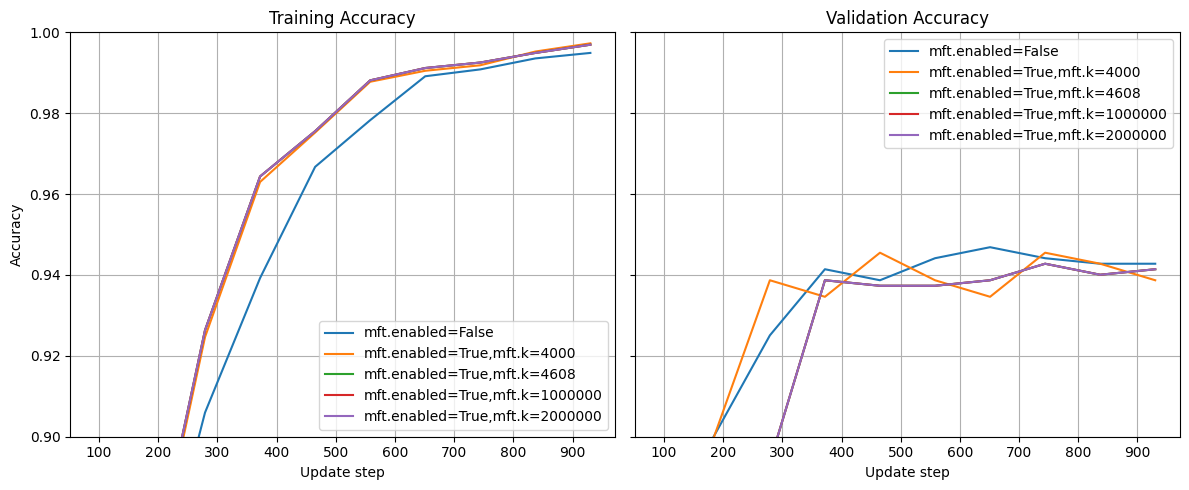

In [14]:
%reload_ext autoreload
%autoreload 2

from typing import Literal
import augmentation
from augmentation import AugmentationParams
from training import TrainParams, NagParams
from freezing import MaskedFineTuningParams
from evaluation import evaluate_test_accuracy_and_misclassified
from datasets import DatasetParams
from evaluation import override_param_sets, evaluate_runs_ci, evaluate_runs_print
from run import run_multiple

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    #class_fractions=(0.2,)*37,
    class_fractions=(1.0,) * 37,
    validation_set_fraction=0.2,  # 20 % of trainval set
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.0055905797197103695,
        weight_decay=9.123321505007701e-06,
        momentum=0.791610254744395,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 4),
    augmentation=AugmentationParams(
        enabled=True,
        transform=augmentation.to_transform(architecture, ["resize", "flip"])
    ),
    mft=MaskedFineTuningParams(
        enabled=False,
        k=100,
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

overrides = [
    dict(mft=dict(enabled=False)),
    dict(mft=dict(enabled=True, k=4000)),
    dict(mft=dict(enabled=True, k=4608)),
    dict(mft=dict(enabled=True, k=1000000)),
    dict(mft=dict(enabled=True, k=2000000)),
]
param_sets = override_param_sets(baseline_params, overrides)
results = run_multiple(dataset_params, param_sets, determinism, invalidate=False, trials=1)
evaluate_runs_print(results)
evaluate_runs_ci(results)


# Test model

In [ ]:

from run import try_loading_trainer
from evaluation import evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning

suppress_weights_only_warning()

eval_params = baseline_params.copy()

eval_params.n_epochs = 20
eval_params.augmentation.enabled = True
eval_params.augmentation.transform = augmentation.auto_transform(eval_params.architecture)
eval_params.optimizer.learning_rate = 0.005
eval_params.optimizer.weight_decay = 2.0e-05

trainer = try_loading_trainer(dataset_params, eval_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(eval_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

final_test_acc = evaluate_test_accuracy(trainer, test_loader)

print(f"Final Test Accuracy: {final_test_acc:.2f}%")

# Misclassified images

In [ ]:
from evaluation import show_misclassified

final_test_acc, misclassified_samples = evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Number of misclassified samples: {len(misclassified_samples)}")
show_misclassified(misclassified_samples)